In [12]:
import pandas as pd
import wfdb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import h5py

In [11]:
 # Load labels
sami_trop_df = pd.read_csv('../data/Sami-Trop.csv')
sami_trop_df.sort_values(by='exam_id', ascending=True, inplace=True)
sami_trop_df.head()

,exam_id,age,is_male,normal_ecg,death,timey,nn_predicted_age
286,3629,54,True,False,False,1.933700,74.098280
1012,4991,85,False,False,False,2.240329,82.126080
1020,8760,29,True,False,False,2.160219,67.648590
1074,18511,75,False,False,False,2.433699,46.081425
514,20122,85,False,False,False,2.011048,64.305140


In [10]:
sami_trop_df.dtypes

exam_id               int64
age                   int64
is_male                bool
normal_ecg             bool
death                  bool
timey               float64
nn_predicted_age    float64
dtype: object

In [13]:
with h5py.File("../data/Sami-Trop.hdf5") as f: 
    tracings = f['tracings'][:]
tracings.shape

(1631, 4096, 12)

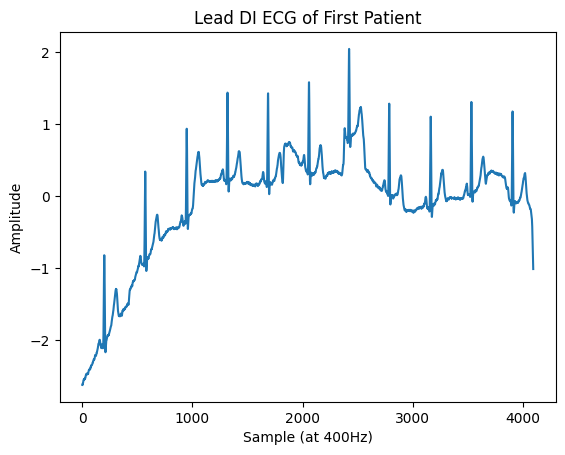

In [15]:
example_ecg = tracings[0]

# Plot one lead
import matplotlib.pyplot as plt

plt.plot(example_ecg[:, 0])  # Lead DI
plt.title("Lead DI ECG of First Patient")
plt.xlabel("Sample (at 400Hz)")
plt.ylabel("Amplitude")
plt.show()